In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from geotiff_processor import GeotiffProcessor
from ice_modeler import IceModeler

Using TensorFlow backend.


In [3]:
geotiff_index = pd.read_csv('daily_northern_geotiff_index.csv')
geotiff_index.date = pd.to_datetime(geotiff_index.date)
geotiff_index = geotiff_index.set_index('date')

In [4]:
geotiff_concentration = geotiff_index.loc[geotiff_index.image_type == 'concentration']

In [5]:
conc_last_ten = geotiff_index.loc['2009-01-01':'2018-12-31',:]

In [6]:
conc_processor = GeotiffProcessor('raw_images/', image_index=conc_last_ten)

In [7]:
conc_processor.load_default_colormaps(
    extent='default_extent_colormap.pkl',
    concentration='default_concentration_colormap.pkl')

In [8]:
ice_modeler = IceModeler()

In [11]:
conc_images_flat = conc_processor.process_images_keras_lstm()

In [12]:
x_train = conc_images_flat[:,:1461,:]
y_train = conc_images_flat[:,365:1826,:]

In [41]:
scaled_tanh = ice_modeler.make_hard_tanh(1)

In [83]:
ice_modeler.reset_model()
ice_modeler.add_n_tcn(1, nb_filters=8, kernel_size=7, nb_stacks=2)
ice_modeler.add_n_tcn(1, nb_filters=4, kernel_size=14, nb_stacks=4)
#ice_modeler.add_n_tcn(1, nb_filters=5, kernel_size=14, nb_stacks=4)
#ice_modeler.add_n_tcn(1, nb_filters=5, kernel_size=30, nb_stacks=4)
ice_modeler.add_n_dense(1, ice_modeler.image_size)

In [84]:
mean_squared_error = ice_modeler.make_power_error(2)
ice_modeler.compile(loss=mean_squared_error, optimizer='adam')

In [89]:
ice_modeler.fit(x_train, y_train, epochs=5)

Epoch 1/5
1/1 [==============================] - 35s 35s/step - loss: 0.1076
Epoch 2/5
1/1 [==============================] - 30s 30s/step - loss: 0.0703
Epoch 3/5
1/1 [==============================] - 28s 28s/step - loss: 0.0417
Epoch 4/5
1/1 [==============================] - 29s 29s/step - loss: 0.0297
Epoch 5/5
1/1 [==============================] - 29s 29s/step - loss: 0.0240


In [90]:
test_frames = conc_images_flat[:,1826:1836,:]
groud_truths = conc_images_flat[:2191:2201,:]
test_preds = ice_modeler.predict(test_frames)
print(test_preds.shape)
pred_images = ice_modeler.reshape_to_image(test_preds)

(1, 10, 136192)


In [91]:
pred_images.shape

(1, 10, 448, 304)

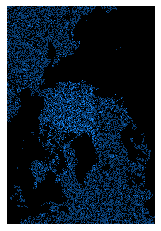

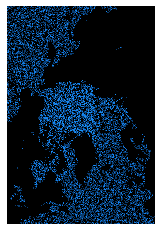

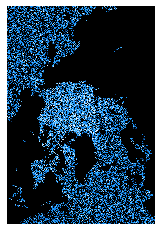

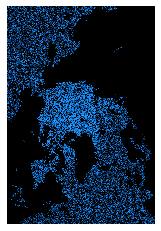

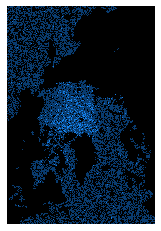

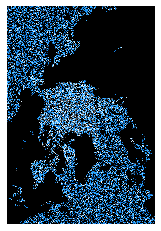

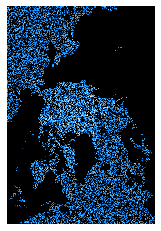

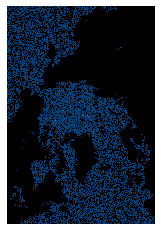

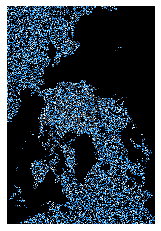

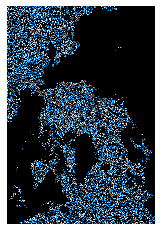

In [92]:
for i in range(10):
    conc_processor.make_colored_prediction_image(pred_images[:,i,:], 'concentration')

In [94]:
conc_processor.process_images_keras_channels_first_yearly_sample()

2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
